In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import label_binarize

# Dataset Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [6]:
train_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/train", transform=transform)
val_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/validation", transform=transform)
test_dataset = datasets.ImageFolder("/kaggle/input/indianfood15/IndianFood15/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Load  Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet169 = models.densenet169(pretrained=True)

# Modify classifier for dataset
num_classes = 15
densenet169.classifier = nn.Linear(densenet169.classifier.in_features, num_classes)
densenet169 = densenet169.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet169.parameters(), lr=0.001)

In [8]:
# Training and Validation Loop
num_epochs = 30
metrics = {
    "train_loss": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(num_epochs):
    # Training Phase
    densenet169.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = densenet169(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    metrics["train_loss"].append(running_loss / len(train_loader))
    
    # Validation Phase
    densenet169.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = densenet169(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    metrics["val_loss"].append(val_loss / len(val_loader))
    metrics["val_accuracy"].append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {correct / total:.4f}")

torch.save(densenet169.state_dict(), "densenet169_finetuned.pth")

Epoch 1/30, Train Loss: 0.9274, Val Loss: 0.7257, Val Accuracy: 0.7906
Epoch 2/30, Train Loss: 0.5440, Val Loss: 0.6308, Val Accuracy: 0.8102
Epoch 3/30, Train Loss: 0.4123, Val Loss: 0.5273, Val Accuracy: 0.8555
Epoch 4/30, Train Loss: 0.3513, Val Loss: 0.5857, Val Accuracy: 0.8409
Epoch 5/30, Train Loss: 0.3066, Val Loss: 0.4555, Val Accuracy: 0.8604
Epoch 6/30, Train Loss: 0.2485, Val Loss: 0.4510, Val Accuracy: 0.8688
Epoch 7/30, Train Loss: 0.2064, Val Loss: 0.7117, Val Accuracy: 0.8074
Epoch 8/30, Train Loss: 0.1875, Val Loss: 0.4920, Val Accuracy: 0.8660
Epoch 9/30, Train Loss: 0.1737, Val Loss: 0.4616, Val Accuracy: 0.8779
Epoch 10/30, Train Loss: 0.1111, Val Loss: 0.5192, Val Accuracy: 0.8723
Epoch 11/30, Train Loss: 0.1580, Val Loss: 0.7139, Val Accuracy: 0.8367
Epoch 12/30, Train Loss: 0.1379, Val Loss: 0.5594, Val Accuracy: 0.8562
Epoch 13/30, Train Loss: 0.1207, Val Loss: 0.4853, Val Accuracy: 0.8814
Epoch 14/30, Train Loss: 0.0952, Val Loss: 0.9172, Val Accuracy: 0.8158
E

In [12]:
# Test Eval
densenet169.eval()
test_labels = []
test_preds = []
test_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet169(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_labels.extend(labels.cpu().numpy()) # Actual labels
        test_preds.extend(preds.cpu().numpy())   # Predicted labels
        test_probs.extend(probs.cpu().numpy())   # Probability distributions

# Error solution for one-hot encoding for mAP computation
test_labels_one_hot = label_binarize(test_labels, classes=range(num_classes))

# Metrics
precision = precision_score(test_labels, test_preds, average="macro")
recall = recall_score(test_labels, test_preds, average="macro")
f1 = f1_score(test_labels, test_preds, average="macro")
map_score = average_precision_score(test_labels_one_hot, test_probs, average="macro")

print(f"\nTest Metrics:\n"
      f"Precision: {precision:.4f}\n"
      f"Recall: {recall:.4f}\n"
      f"F1-Score: {f1:.4f}\n"
      f"mAP: {map_score:.4f}")



Test Metrics:
Precision: 0.8531
Recall: 0.8435
F1-Score: 0.8386
mAP: 0.9341


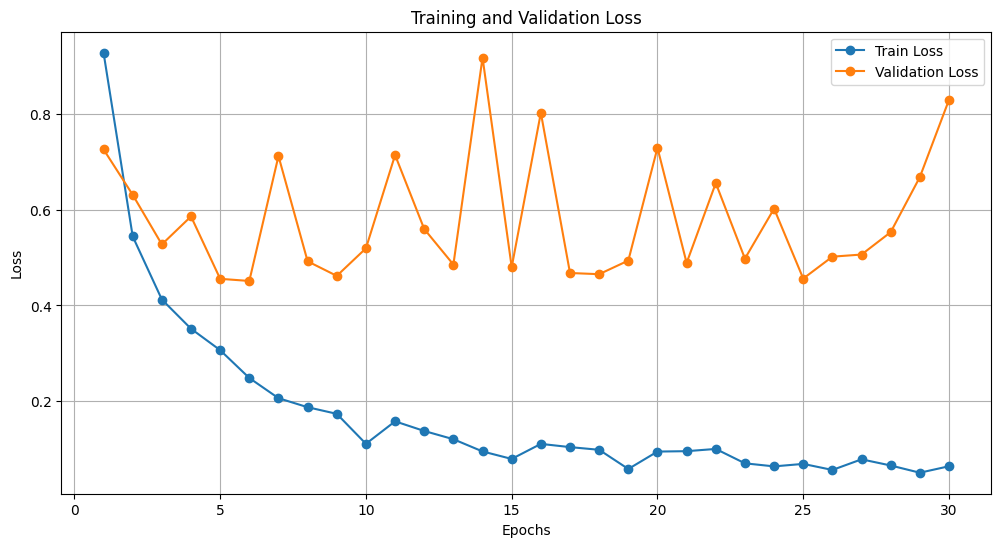

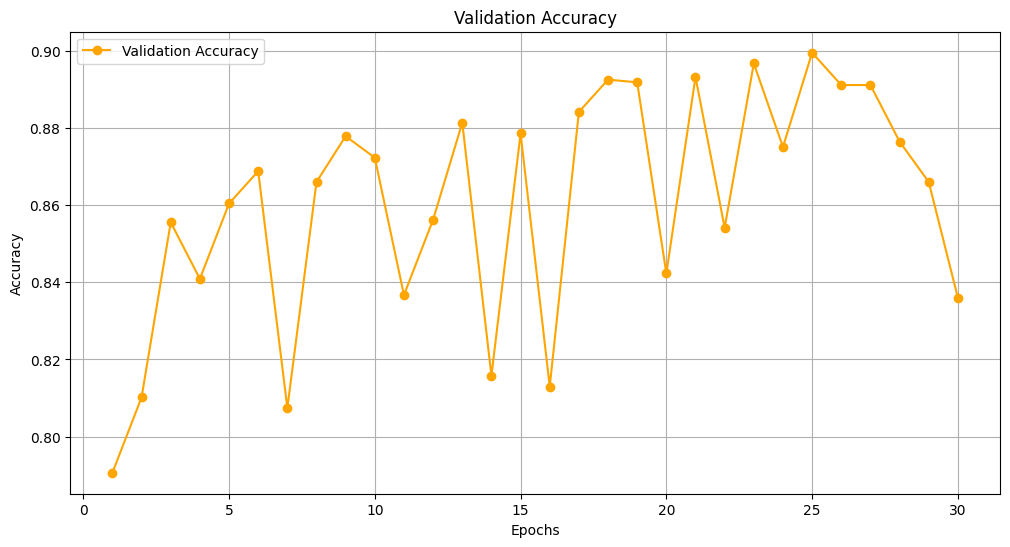

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), metrics["train_loss"], label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), metrics["val_loss"], label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), metrics["val_accuracy"], label="Validation Accuracy", marker='o', color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()